# Sentiment Analysis and Predictions on Twitter Reviews

- **Sevi Yfanti - 1994**
- **Vasilis Zaridis - 2013**
- **Panagiotis Grigoriadis - 1833**

## All our libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import Dense, Input, Flatten, GlobalMaxPooling1D

from sklearn.pipeline import Pipeline

from textblob import TextBlob

from mpl_toolkits.basemap import Basemap

import nltk
from nltk.corpus import stopwords

import seaborn as sns
import re
import sys

import time

Using TensorFlow backend.


# Load Dataset

In [2]:
df = pd.read_csv("Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Preprocessing - Analysis

## Handle useless variables and NAN's

### Drop useless variables

In [4]:
df=df.drop(['tweet_id'],axis=1)
df=df.drop(['name'],axis=1)

### Count the variables

In [5]:
df.count()

airline_sentiment               14640
airline_sentiment_confidence    14640
negativereason                   9178
negativereason_confidence       10522
airline                         14640
airline_sentiment_gold             40
negativereason_gold                32
retweet_count                   14640
text                            14640
tweet_coord                      1019
tweet_created                   14640
tweet_location                   9907
user_timezone                    9820
dtype: int64

### Remove columns: airline_sentiment_gold , negativereason_gold  because of high NaNs percentage

In [6]:
df=df.drop(['airline_sentiment_gold'],axis=1)
df=df.drop(['negativereason_gold'],axis=1)

### Handle missing numeric variables

In [7]:
## Fill nans in regative_reason_confidence with 0. Ta 0 mpainoun stis katigories possitive kai neutral mias kai den exoun negative reason
df.negativereason_confidence=df.negativereason_confidence.fillna(0)


## Detect location of tweets in WordMap

### Split Input and Output values

In [8]:
dataset = df
dataset = dataset.fillna(0)
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:,0].values

In [9]:
#Encoding categorical target values
from sklearn.preprocessing import LabelEncoder

labelencoder_y = LabelEncoder()
y[:] = labelencoder_y.fit_transform(y[:])

In [10]:
#matrix with the coordinates only
coords = X[:,6] #this is the column with all the coord

In [11]:
#create list with correct coordinates(not the zeros)
#and another with the sentiment of each tweet
list_coord = []
list_sent = []
length = y.size
for i in range(length):
    if coords[i] != 0 and coords[i] != '[0.0, 0.0]':
        list_coord.append(coords[i])
        list_sent.append(y[i])

In [12]:
#split latitude and longtitude
# = list_coord.split(", ")
lat = []
long = []
for i in list_coord:
    x = i.split(",")
    #delete []
    lat.append(x[0][1:])
    long.append(x[1][:-1])
    
l = len(lat)
lat_int = []
long_int = []
for i in range(l): 
    lat_int.append(float(lat[i]))
    long_int.append(float(long[i]))


In [13]:
from mpl_toolkits.basemap import Basemap

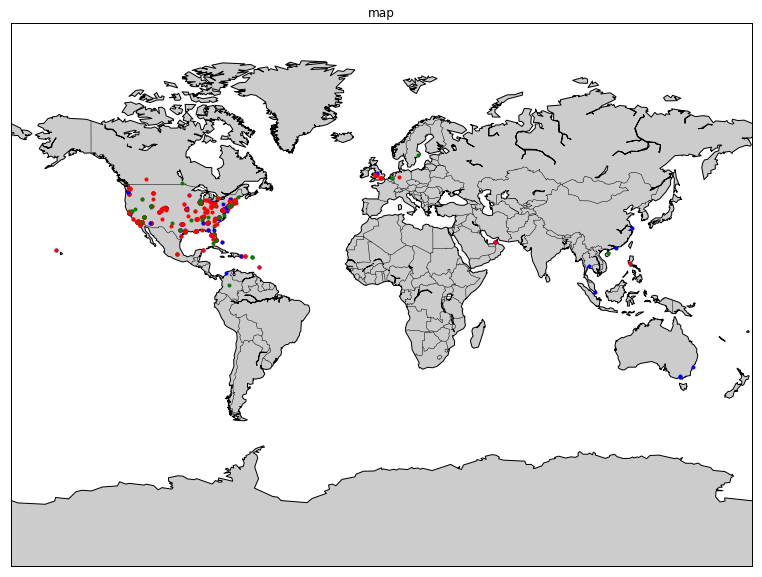

In [14]:
plt.figure(figsize= (20,10))

map = Basemap(projection='mill',llcrnrlat = -90,urcrnrlat=90,llcrnrlon = -180, urcrnrlon = 180, resolution='c')
map.drawcoastlines()
map.drawcountries()
map.fillcontinents( lake_color='#FFFFFF')
map.drawmapboundary(fill_color = '#FFFFFF')

for i in range(l):
    x,y = map(long_int[i], lat_int[i])
    if list_sent[i] == 0:
        map.plot(x,y,'r.')
    if list_sent[i] == 1:
        map.plot(x,y,'b.')
    if list_sent[i] == 2:
        map.plot(x,y,'g.')
map.bluemarble()
plt.title('map')
plt.savefig( 'map.pdf', bbox_inches='tight', pad_inches=0 )
plt.show()

## Sampling based on classes

In [15]:
positive=df[df['airline_sentiment']=='positive']
neutral=df[df['airline_sentiment']=='neutral'].sample(n=positive.shape[0])
negative=df[df['airline_sentiment']=='negative'].sample(n=positive.shape[0])

equal_sample=pd.concat([positive,negative,neutral])

###  Sentiment analisys on every airline company

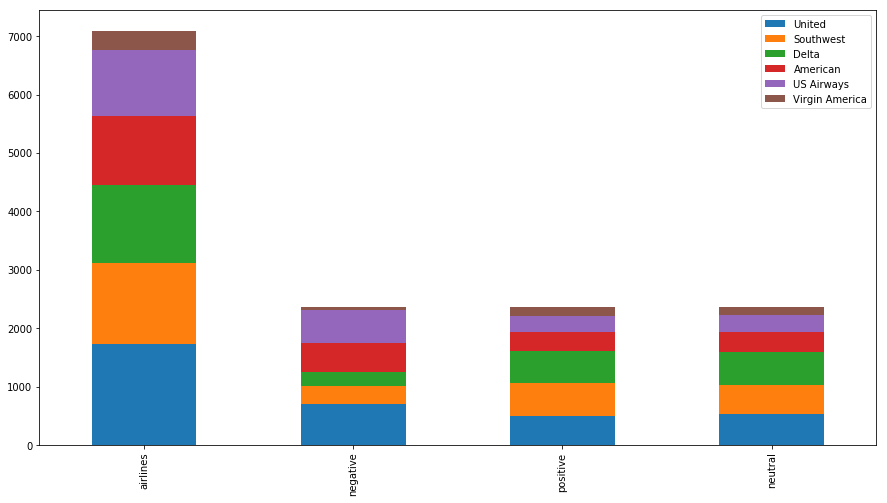

In [16]:
all_negatives=equal_sample['airline'].value_counts()
negative=equal_sample[equal_sample['airline_sentiment']=='negative']['airline'].value_counts()
positive=equal_sample[equal_sample['airline_sentiment']=='positive']['airline'].value_counts()
neutral=equal_sample[equal_sample['airline_sentiment']=='neutral']['airline'].value_counts()
qf=pd.DataFrame([all_negatives,negative,positive,neutral])
qf.index=['airlines','negative','positive','neutral']
qf.plot(kind='bar',stacked=True,figsize=(15,8))
plt.show()

**We observe that companies : United, American,US Airlines have more negative reviews than positive. In contrast Virgin America ,Dela and Southwest have more positive.**

### Analysis on negative reason

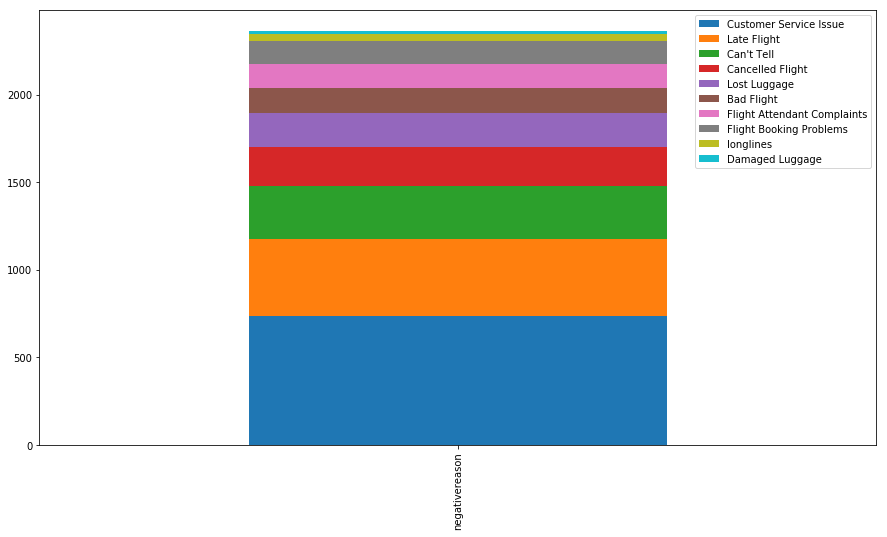

In [17]:
all_negatives=equal_sample['negativereason'].value_counts()
negative=equal_sample[equal_sample['airline_sentiment']=='negative']['negativereason'].value_counts()
qf=pd.DataFrame([negative])
#qf.index=['booked','cancelled','not_cancelled']
qf.plot(kind='bar',stacked=True,figsize=(15,8))
plt.show()

**We observe tha the most common reason for negative reviews is Customer Service Issue**

In [18]:
f=df.groupby(['airline_sentiment']).size()
f

airline_sentiment
negative    9178
neutral     3099
positive    2363
dtype: int64

In [19]:
df.groupby(['airline']).size()

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
dtype: int64

### Handle categorical variables (One-Hot encoding) 

In [20]:
from sklearn.preprocessing import LabelEncoder

oh_negativereason = pd.get_dummies(df.negativereason).astype(int)
#oh_negativereason.columns = ['travel_type_1','travel_type_2','travel_type_3']

df = pd.concat((df, oh_negativereason), axis = 1)
df=df.drop(['negativereason'],axis=1)

oh_airline = pd.get_dummies(df.airline).astype(int)
#oh_negativereason.columns = ['travel_type_1','travel_type_2','travel_type_3']

df = pd.concat((df, oh_airline), axis = 1)
df=df.drop(['airline'],axis=1)

oh_airline_setiment = pd.get_dummies(df.airline_sentiment).astype(int)
#oh_negativereason.columns = ['travel_type_1','travel_type_2','travel_type_3']

df = pd.concat((df, oh_airline_setiment), axis = 1)
labelencoder_y = LabelEncoder()

In [21]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,Bad Flight,...,longlines,American,Delta,Southwest,US Airways,United,Virgin America,negative,neutral,positive
0,neutral,1.0000,0.0000,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0,...,0,0,0,0,0,0,1,0,1,0
1,positive,0.3486,0.0000,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),0,...,0,0,0,0,0,0,1,0,0,1
2,neutral,0.6837,0.0000,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),0,...,0,0,0,0,0,0,1,0,1,0
3,negative,1.0000,0.7033,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),1,...,0,0,0,0,0,0,1,1,0,0
4,negative,1.0000,1.0000,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0,...,0,0,0,0,0,0,1,1,0,0


## check total and each airline's stats

For all airlines:
Positive: 2363 16.14071038251366 %
Neautral: 3099 21.168032786885245 %
Negative: 9178 62.69125683060109 %


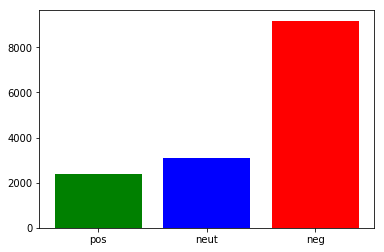

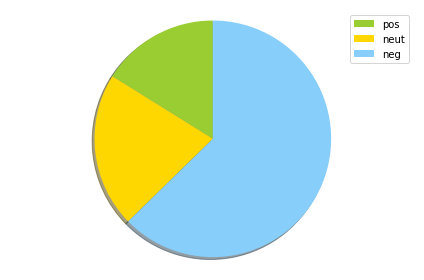

In [22]:
count = df.shape[0]
pos = df[df['positive'] == 1].shape[0]
neut = df[df['neutral'] == 1].shape[0]
neg = df[df['negative'] == 1].shape[0]

print ('For all airlines:')
print ('Positive:', pos, pos*100/count, '%')
print ('Neautral:', neut, neut*100/count, '%')
print ('Negative:', neg, neg*100/count, '%')

y = [pos, neut, neg]
x = ['pos', 'neut', 'neg']
plt.bar(x,y, color = ['g', 'b', 'r'])
plt.show()

colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts = plt.pie(y, colors=colors, shadow=True, startangle=90)
plt.legend(patches, x, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

For Us Airways:
Positive: 269 9.234466186062479 %
Neautral: 381 13.079299691040164 %
Negative: 2263 77.68623412289736 %


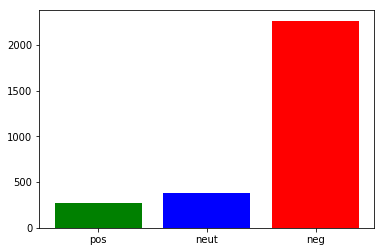

In [23]:
df1 = df[df['US Airways'] == 1]
count = df1.shape[0]
pos = df1[df1['positive'] == 1].shape[0]
neut = df1[df1['neutral'] == 1].shape[0]
neg = df1[df1['negative'] == 1].shape[0]

print ('For Us Airways:')
print ('Positive:', pos, pos*100/count, '%')
print ('Neautral:', neut, neut*100/count, '%')
print ('Negative:', neg, neg*100/count, '%')

y = [pos, neut, neg]
x = ['pos', 'neut', 'neg']
plt.bar(x,y, color = ['g', 'b', 'r'])
plt.show()

For United:
Positive: 492 12.872841444270016 %
Neautral: 697 18.236525379382524 %
Negative: 2633 68.89063317634746 %


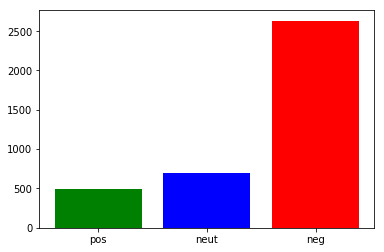

In [24]:
df2 = df[df['United'] == 1]
count = df2.shape[0]
pos = df2[df2['positive'] == 1].shape[0]
neut = df2[df2['neutral'] == 1].shape[0]
neg = df2[df2['negative'] == 1].shape[0]

print ('For United:')
print ('Positive:', pos, pos*100/count, '%')
print ('Neautral:', neut, neut*100/count, '%')
print ('Negative:', neg, neg*100/count, '%')

y = [pos, neut, neg]
x = ['pos', 'neut', 'neg']
plt.bar(x,y, color = ['g', 'b', 'r'])
plt.show()

For Virgin America:
Positive: 152 30.158730158730158 %
Neautral: 171 33.92857142857143 %
Negative: 181 35.91269841269841 %


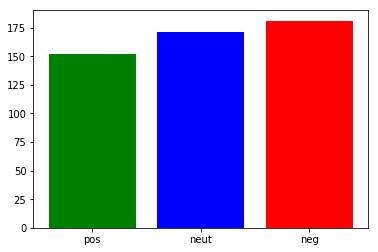

In [25]:
df3 = df[df['Virgin America'] == 1]
count = df3.shape[0]
pos = df3[df3['positive'] == 1].shape[0]
neut = df3[df3['neutral'] == 1].shape[0]
neg = df3[df3['negative'] == 1].shape[0]

print ('For Virgin America:')
print ('Positive:', pos, pos*100/count, '%')
print ('Neautral:', neut, neut*100/count, '%')
print ('Negative:', neg, neg*100/count, '%')

y = [pos, neut, neg]
x = ['pos', 'neut', 'neg']
plt.bar(x,y, color = ['g', 'b', 'r'])
plt.show()

For Southwest:
Positive: 570 23.553719008264462 %
Neautral: 664 27.43801652892562 %
Negative: 1186 49.00826446280992 %


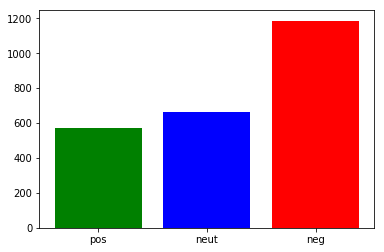

In [26]:
df3 = df[df['Southwest'] == 1]
count = df3.shape[0]
pos = df3[df3['positive'] == 1].shape[0]
neut = df3[df3['neutral'] == 1].shape[0]
neg = df3[df3['negative'] == 1].shape[0]

print ('For Southwest:')
print ('Positive:', pos, pos*100/count, '%')
print ('Neautral:', neut, neut*100/count, '%')
print ('Negative:', neg, neg*100/count, '%')

y = [pos, neut, neg]
x = ['pos', 'neut', 'neg']
plt.bar(x,y, color = ['g', 'b', 'r'])
plt.show()

For Delta:
Positive: 544 24.482448244824482 %
Neautral: 723 32.53825382538254 %
Negative: 955 42.97929792979298 %


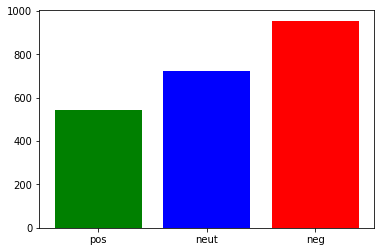

In [27]:
df3 = df[df['Delta'] == 1]
count = df3.shape[0]
pos = df3[df3['positive'] == 1].shape[0]
neut = df3[df3['neutral'] == 1].shape[0]
neg = df3[df3['negative'] == 1].shape[0]

print ('For Delta:')
print ('Positive:', pos, pos*100/count, '%')
print ('Neautral:', neut, neut*100/count, '%')
print ('Negative:', neg, neg*100/count, '%')

y = [pos, neut, neg]
x = ['pos', 'neut', 'neg']
plt.bar(x,y, color = ['g', 'b', 'r'])
plt.show()

For American:
Positive: 336 12.178325480246466 %
Neautral: 463 16.78144255164915 %
Negative: 1960 71.04023196810438 %


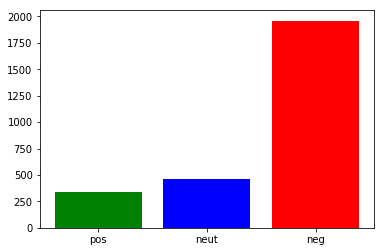

In [28]:
df3 = df[df['American'] == 1]
count = df3.shape[0]
pos = df3[df3['positive'] == 1].shape[0]
neut = df3[df3['neutral'] == 1].shape[0]
neg = df3[df3['negative'] == 1].shape[0]

print ('For American:')
print ('Positive:', pos, pos*100/count, '%')
print ('Neautral:', neut, neut*100/count, '%')
print ('Negative:', neg, neg*100/count, '%')

y = [pos, neut, neg]
x = ['pos', 'neut', 'neg']
plt.bar(x,y, color = ['g', 'b', 'r'])
plt.show()

# Natural language processing

## make copies of dataframe

In [29]:
nlp_process = df.text

In [30]:
nlp_process_neural = pd.concat((nlp_process, df.airline_sentiment), axis = 1)

In [31]:
df['airline_sentiment']= labelencoder_y.fit_transform(df['airline_sentiment'])

In [32]:
nlp_process_neural.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [33]:
nlp_process = pd.concat((nlp_process, df.positive), axis = 1)
nlp_process = pd.concat((nlp_process, df.negative), axis = 1)
nlp_process = pd.concat((nlp_process, df.neutral), axis = 1)

In [34]:
nlp_process[nlp_process['positive']==1].head()

,text,positive,negative,neutral
1,@VirginAmerica plus you've added commercials t...,1,0,0
6,"@VirginAmerica yes, nearly every time I fly VX...",1,0,0
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",1,0,0
9,"@VirginAmerica it was amazing, and arrived an ...",1,0,0
11,@VirginAmerica I &lt;3 pretty graphics. so muc...,1,0,0


## Removing Twitter Handles (@user)

In [35]:
import re
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [36]:
nlp_process['text'] = np.vectorize(remove_pattern)(nlp_process['text'], "@[\w]*") 
nlp_process.head()

,text,positive,negative,neutral
0,What said.,0,0,1
1,plus you've added commercials to the experien...,1,0,0
2,I didn't today... Must mean I need to take an...,0,0,1
3,"it's really aggressive to blast obnoxious ""en...",0,1,0
4,and it's a really big bad thing about it,0,1,0


In [37]:
nlp_process_neural['text'] = np.vectorize(remove_pattern)(nlp_process_neural['text'], "@[\w]*") 


## Removing Punctuations, Numbers, and Special Characters

In [38]:
nlp_process['text'] = nlp_process['text'].str.replace("[^a-zA-Z#]", " ")
nlp_process.head(10)

,text,positive,negative,neutral
0,What said,0,0,1
1,plus you ve added commercials to the experien...,1,0,0
2,I didn t today Must mean I need to take an...,0,0,1
3,it s really aggressive to blast obnoxious en...,0,1,0
4,and it s a really big bad thing about it,0,1,0
5,seriously would pay a flight for seats th...,0,1,0
6,yes nearly every time I fly VX this ear wor...,1,0,0
7,Really missed a prime opportunity for Men Wit...,0,0,1
8,Well I didn t but NOW I DO D,1,0,0
9,it was amazing and arrived an hour early Yo...,1,0,0


In [39]:
nlp_process_neural['text'] = nlp_process_neural['text'].str.replace("[^a-zA-Z#]", " ")

## Removal of Stop Words

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pgrig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
nlp_process['text'] = nlp_process['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
nlp_process.head(15)

,text,positive,negative,neutral
0,What said,0,0,1
1,plus added commercials experience tacky,1,0,0
2,I today Must mean I need take another trip,0,0,1
3,really aggressive blast obnoxious entertainmen...,0,1,0
4,really big bad thing,0,1,0
5,seriously would pay flight seats playing reall...,0,1,0
6,yes nearly every time I fly VX ear worm go away,1,0,0
7,Really missed prime opportunity Men Without Ha...,0,0,1
8,Well I NOW I DO D,1,0,0
9,amazing arrived hour early You good,1,0,0


In [42]:
nlp_process_neural['text'] = nlp_process_neural['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## Removing Short Words

In [43]:
nlp_process['text'] = nlp_process['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [44]:
nlp_process_neural['text'] = nlp_process_neural['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [45]:
nlp_process.head(10)

,text,positive,negative,neutral
0,What said,0,0,1
1,plus added commercials experience tacky,1,0,0
2,today Must mean need take another trip,0,0,1
3,really aggressive blast obnoxious entertainmen...,0,1,0
4,really thing,0,1,0
5,seriously would flight seats playing really th...,0,1,0
6,nearly every time worm away,1,0,0
7,Really missed prime opportunity Without Hats p...,0,0,1
8,Well,1,0,0
9,amazing arrived hour early good,1,0,0


## Lower Case

In [46]:
nlp_process['text'] = nlp_process['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
nlp_process.head(9)

,text,positive,negative,neutral
0,what said,0,0,1
1,plus added commercials experience tacky,1,0,0
2,today must mean need take another trip,0,0,1
3,really aggressive blast obnoxious entertainmen...,0,1,0
4,really thing,0,1,0
5,seriously would flight seats playing really th...,0,1,0
6,nearly every time worm away,1,0,0
7,really missed prime opportunity without hats p...,0,0,1
8,well,1,0,0


In [47]:
nlp_process_neural['text'] = nlp_process_neural['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

## Rare words removal

In [48]:
freq = pd.Series(' '.join(nlp_process['text']).split()).value_counts()[-10:]
req = list(freq.index)
nlp_process['text'] = nlp_process['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
nlp_process.head()

,text,positive,negative,neutral
0,what said,0,0,1
1,plus added commercials experience tacky,1,0,0
2,today must mean need take another trip,0,0,1
3,really aggressive blast obnoxious entertainmen...,0,1,0
4,really thing,0,1,0


In [49]:
nlp_process_neural['text'] = nlp_process_neural['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

##  Story Generation and Visualization from Tweets (Wordcloud)

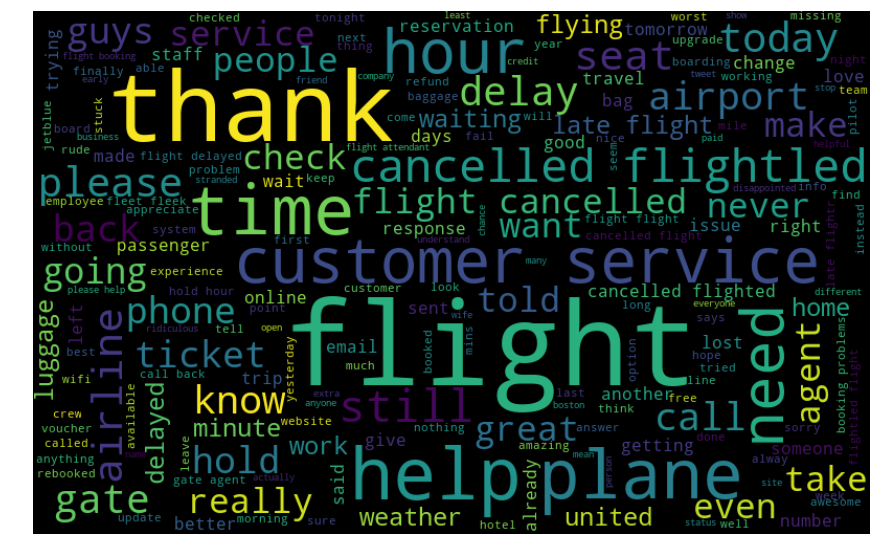

In [50]:
all_words = ' '.join([text for text in nlp_process['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Understanding the impact of Hashtags on tweets sentiment

In [51]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [52]:
# extracting hashtags from neutral tweets

HT_neutral = hashtag_extract(nlp_process['text'][nlp_process['neutral'] == 1])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(nlp_process['text'][nlp_process['negative'] == 1])

# extracting hashtags from negative tweets
HT_positive = hashtag_extract(nlp_process['text'][nlp_process['positive'] == 1])

# unnesting list
HT_neutral = sum(HT_neutral,[])
HT_negative = sum(HT_negative,[])
HT_positive = sum(HT_positive,[])

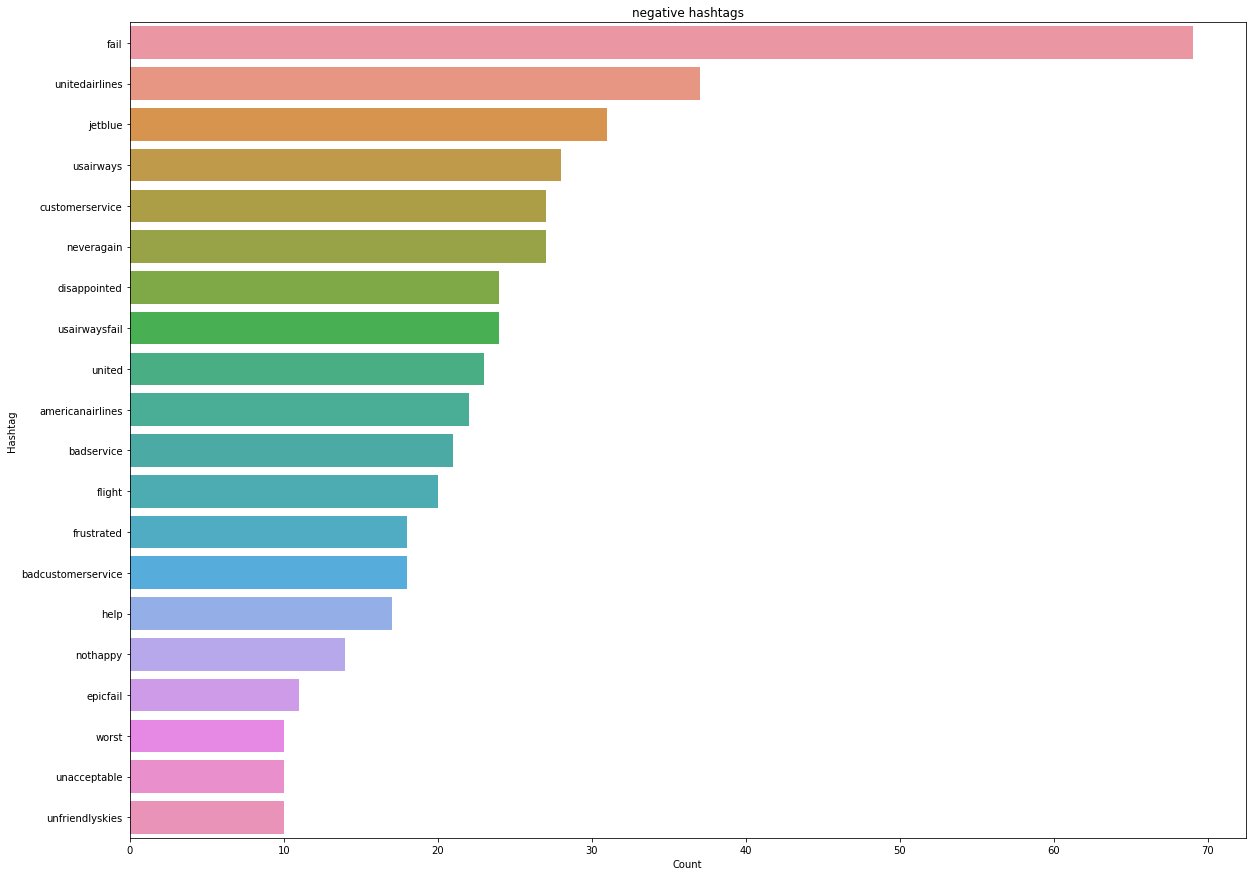

In [53]:
import nltk
import seaborn as sns
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(20,15))
ax = sns.barplot(data=d, x= "Count", y = "Hashtag")
ax.set(xlabel = 'Count')
ax.set(title = 'negative hashtags')
plt.show()

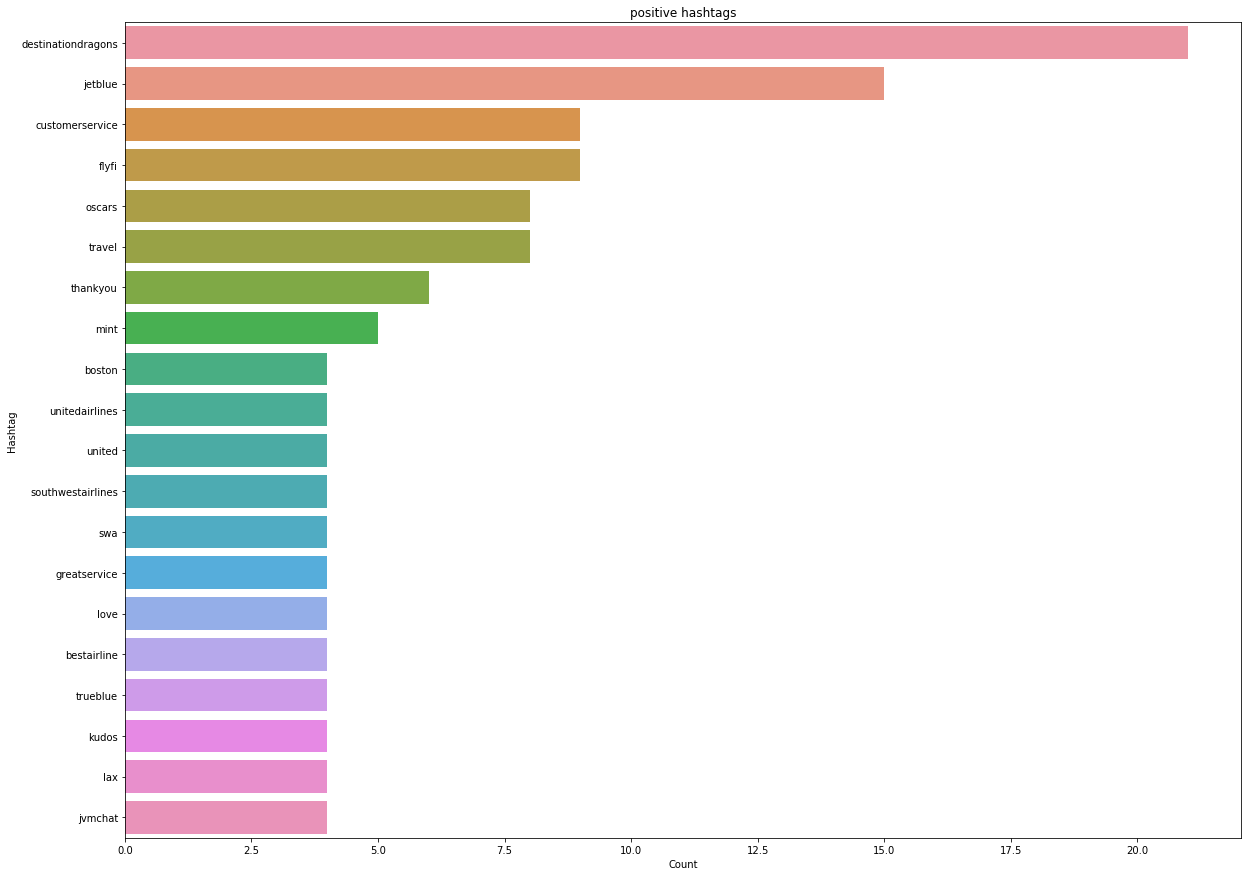

In [54]:
a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(20,15))
ax = sns.barplot(data=d, x= "Count", y = "Hashtag")
ax.set(xlabel = 'Count')
ax.set(title = 'positive hashtags')

plt.show()

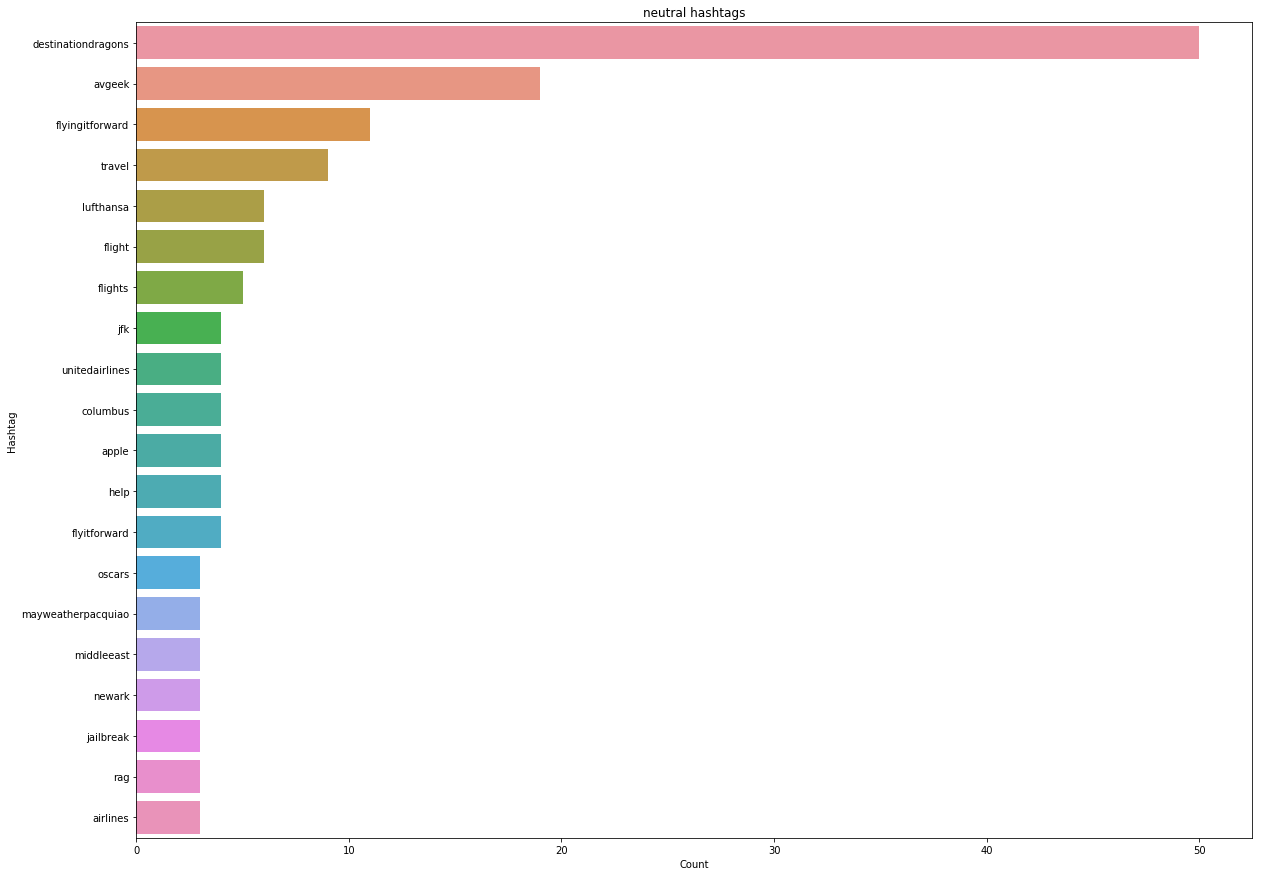

In [55]:
a = nltk.FreqDist(HT_neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(20,15))
ax = sns.barplot(data=d, x= "Count", y = "Hashtag")
ax.set(xlabel = 'Count')
ax.set(title = 'neutral hashtags')

plt.show()

## Extracting Features from Cleaned Tweets


***Word Embeddings***

A word embedding is a learned representation for text where words that have the same meaning have a similar representation.

Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [57]:
nlp_process['text'].head()

0                                            what said
1              plus added commercials experience tacky
2               today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                         really thing
Name: text, dtype: object

In [58]:
#Bag-of-Words Features¶

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(nlp_process['text'])
bow.shape

(14640, 1000)

In [59]:
#TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(nlp_process['text'])
tfidf.shape

(14640, 1000)

In [60]:
# Word2Vec Embeddings

In [61]:
tokenized_tweet = nlp_process['text'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(nlp_process['text']), epochs=20)

(1841889, 2204520)

In [62]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [63]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(14640, 200)

# Apply classic ML models (only text column)

## Load some libraries

In [64]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [65]:
accuracy_list = []

## Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
def logistic(X,y):
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)
    
    model = LogisticRegression(random_state=0, solver='lbfgs',
                             max_iter = 300, multi_class='multinomial')
    
    start_time = time.time()
    model.fit(xtrain, ytrain)
    elapsed_time = time.time() - start_time
    
    y_pred = model.predict(xvalid)
    acc = metrics.accuracy_score(yvalid, y_pred)
    print ('Accuracy:',acc)
    print ('Confusion matrix:\n',confusion_matrix(yvalid, y_pred)) 
    
    print ('\nElapsed time:', elapsed_time, 'sec')
    accuracy_list.append(acc)

### Bag-of-Words Features

In [68]:
logistic(bow,df['airline_sentiment'])

Accuracy: 0.7629781420765027
Confusion matrix:
 [[2460  262   92]
 [ 360  455   69]
 [ 161   97  436]]

Elapsed time: 0.5096840858459473 sec


### TF-IDF Features


In [69]:
logistic(tfidf,df['airline_sentiment'])

Accuracy: 0.7659380692167578
Confusion matrix:
 [[2586  167   61]
 [ 471  364   49]
 [ 208   72  414]]

Elapsed time: 0.42473697662353516 sec


### Word2Vec

In [70]:
logistic(wordvec_df,df['airline_sentiment'])

Accuracy: 0.7784608378870674
Confusion matrix:
 [[2594  161   59]
 [ 408  407   69]
 [ 190   86  418]]

Elapsed time: 1.784898281097412 sec


## SVM

In [71]:
from sklearn.svm import SVC 

In [72]:
def svm(X,y):
    
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)
    
    model = SVC(kernel = 'linear')
    
    start_time = time.time()
    model.fit(xtrain, ytrain)
    elapsed_time = time.time() - start_time
    
    y_pred = model.predict(xvalid)
    acc = metrics.accuracy_score(yvalid, y_pred)
    print ('Accuracy:',acc)
    print ('Confusion matrix:\n',confusion_matrix(yvalid, y_pred)) 
    
    print ('\nElapsed time:', elapsed_time, 'sec')
    accuracy_list.append(acc)

In [73]:
svm(bow,df['airline_sentiment'])

Accuracy: 0.7629781420765027
Confusion matrix:
 [[2436  275  103]
 [ 352  461   71]
 [ 151   89  454]]

Elapsed time: 5.53758430480957 sec


In [74]:
svm(tfidf,df['airline_sentiment'])

Accuracy: 0.7700364298724954
Confusion matrix:
 [[2551  196   67]
 [ 432  399   53]
 [ 187   75  432]]

Elapsed time: 4.153441429138184 sec


In [75]:
svm(wordvec_df,df['airline_sentiment'])

Accuracy: 0.7839253187613844
Confusion matrix:
 [[2620  135   59]
 [ 426  388   70]
 [ 193   66  435]]

Elapsed time: 18.339287757873535 sec


## Decision Tree

In [76]:
from sklearn.tree import DecisionTreeClassifier

In [77]:
def dectree(X,y):
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3)
    
    model = DecisionTreeClassifier(criterion = 'entropy')
    
    start_time = time.time()
    model.fit(xtrain, ytrain)
    elapsed_time = time.time() - start_time
    
    y_pred = model.predict(xvalid)
    acc = metrics.accuracy_score(yvalid, y_pred)
    print ('Accuracy:',acc)
    print ('Confusion matrix:\n',confusion_matrix(yvalid, y_pred)) 
    
    print ('\nElapsed time:', elapsed_time, 'sec')
    accuracy_list.append(acc)

In [78]:
dectree(bow,df['airline_sentiment'])

Accuracy: 0.6598360655737705
Confusion matrix:
 [[2033  510  241]
 [ 321  440  127]
 [ 170  125  425]]

Elapsed time: 0.544731855392456 sec


In [79]:
dectree(tfidf,df['airline_sentiment'])

Accuracy: 0.6857923497267759
Confusion matrix:
 [[2199  408  159]
 [ 360  441  114]
 [ 197  142  372]]

Elapsed time: 0.9977731704711914 sec


In [80]:
dectree(wordvec_df,df['airline_sentiment'])

Accuracy: 0.6466302367941712
Confusion matrix:
 [[2083  398  245]
 [ 367  420  136]
 [ 252  154  337]]

Elapsed time: 5.685260772705078 sec


## RandomForest

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
def randforest(X,y):
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3)
    
    model = RandomForestClassifier(n_estimators=100, random_state = 0)

    start_time = time.time()
    model.fit(xtrain, ytrain)
    elapsed_time = time.time() - start_time
    
    y_pred = model.predict(xvalid)
    acc = metrics.accuracy_score(yvalid, y_pred)
    print ('Accuracy:',acc)
    print ('Confusion matrix:\n',confusion_matrix(yvalid, y_pred)) 
    
    print ('\nElapsed time:', elapsed_time, 'sec')
    accuracy_list.append(acc)

In [83]:
randforest(bow,df['airline_sentiment'])

Accuracy: 0.7254098360655737
Confusion matrix:
 [[2255  337  151]
 [ 358  473  104]
 [ 155  101  458]]

Elapsed time: 5.989933967590332 sec


In [84]:
randforest(tfidf,df['airline_sentiment'])

Accuracy: 0.7370218579234973
Confusion matrix:
 [[2417  206  108]
 [ 425  410  103]
 [ 206  107  410]]

Elapsed time: 6.237497329711914 sec


In [85]:
randforest(wordvec_df,df['airline_sentiment'])

Accuracy: 0.7534153005464481
Confusion matrix:
 [[2604  104   30]
 [ 500  361   58]
 [ 315   76  344]]

Elapsed time: 21.954699993133545 sec


## KNN

In [86]:
from sklearn.neighbors import KNeighborsClassifier

In [87]:
def KNN(X,y):
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3)
    
    model = KNeighborsClassifier(n_neighbors = 6)
    
    start_time = time.perf_counter()
    model.fit(xtrain, ytrain)
    elapsed_time = time.perf_counter() - start_time
    
    y_pred = model.predict(xvalid)
    acc = metrics.accuracy_score(yvalid, y_pred)
    print ('Accuracy:',acc)
    print ('Confusion matrix:\n',confusion_matrix(yvalid, y_pred)) 
    
    print ('\nElapsed time:', elapsed_time, 'sec')
    accuracy_list.append(acc)

In [88]:
KNN(bow,df['airline_sentiment'])

Accuracy: 0.5865209471766849
Confusion matrix:
 [[1672  953  143]
 [ 292  542   99]
 [ 123  206  362]]

Elapsed time: 0.0019850999999988517 sec


In [89]:
KNN(tfidf,df['airline_sentiment'])

Accuracy: 0.473816029143898
Confusion matrix:
 [[1323 1295  164]
 [ 293  527   59]
 [ 181  319  231]]

Elapsed time: 0.00282839999999851 sec


In [90]:
KNN(wordvec_df,df['airline_sentiment'])

Accuracy: 0.7270036429872495
Confusion matrix:
 [[2557  129   50]
 [ 529  319   78]
 [ 335   78  317]]

Elapsed time: 0.17087810000001014 sec


## Gaussian Naive Bayess

In [91]:
from sklearn.naive_bayes import GaussianNB

In [92]:
def nb(X,y):
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3)
    
    model = GaussianNB()
    
    start_time = time.perf_counter()
    model.fit(xtrain, ytrain)
    elapsed_time = time.perf_counter() - start_time
    
    y_pred = model.predict(xvalid)
    acc = metrics.accuracy_score(yvalid, y_pred)
    print ('Accuracy:',acc)
    print ('Confusion matrix:\n',confusion_matrix(yvalid, y_pred)) 
    
    print ('\nElapsed time:', elapsed_time, 'sec')
    accuracy_list.append(acc)

In [93]:
nb(bow.toarray(),df['airline_sentiment'])

Accuracy: 0.38866120218579236
Confusion matrix:
 [[ 790  605 1306]
 [  37  283  653]
 [  25   59  634]]

Elapsed time: 0.25026309999999796 sec


In [94]:
nb(tfidf.toarray(),df['airline_sentiment'])

Accuracy: 0.3697632058287796
Confusion matrix:
 [[ 715  847 1213]
 [  48  323  563]
 [  20   77  586]]

Elapsed time: 0.2605719000000022 sec


In [95]:
nb(wordvec_df,df['airline_sentiment'])

Accuracy: 0.7210837887067395
Confusion matrix:
 [[2351  316   72]
 [ 415  464   81]
 [ 253   88  352]]

Elapsed time: 0.05777210000000821 sec


## Gradient Boosting

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

In [97]:
def gb(X,y):
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.1)
    
    model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth = 4)
    
    start_time = time.time()
    model.fit(xtrain, ytrain)
    elapsed_time = time.time() - start_time
    
    y_pred = model.predict(xvalid)
    acc = metrics.accuracy_score(yvalid, y_pred)
    print ('Accuracy:',acc)
    print ('Confusion matrix:\n',confusion_matrix(yvalid, y_pred)) 
    
    print ('\nElapsed time:', elapsed_time, 'sec')
    accuracy_list.append(acc)

In [98]:
gb(bow,df['airline_sentiment'])

Accuracy: 0.7233606557377049
Confusion matrix:
 [[863  22  25]
 [240  59  24]
 [ 84  10 137]]

Elapsed time: 3.7651779651641846 sec


In [99]:
gb(tfidf,df['airline_sentiment'])

Accuracy: 0.7185792349726776
Confusion matrix:
 [[855  16  21]
 [246  66  26]
 [ 96   7 131]]

Elapsed time: 8.61586618423462 sec


In [100]:
gb(wordvec_df,df['airline_sentiment'])

Accuracy: 0.7834699453551912
Confusion matrix:
 [[863  62  24]
 [123 145  27]
 [ 52  29 139]]

Elapsed time: 130.08456659317017 sec


## Accuracy Diagrams for simple algorithms after BOW, TFIDF & wordVec proccess.

In [101]:
algorithm_list = []
algorithm_list.append('LOGISTIC REGRESSION with bow')
algorithm_list.append('LOGISTIC REGRESSION with tfidf')
algorithm_list.append('LOGISTIC REGRESSION with wordvec')

algorithm_list.append('SVM with bow')
algorithm_list.append('SVM with tfidf')
algorithm_list.append('SVM with wordvec')

algorithm_list.append('DECISION TREE with bow')
algorithm_list.append('DECISION TREE with tfidf')
algorithm_list.append('DECISION TREE with wordvec')

algorithm_list.append('RANDOM FOREST with bow')
algorithm_list.append('RANDOM FOREST with tfidf')
algorithm_list.append('RANDOM FOREST with wordvec')

algorithm_list.append('KNN with bow')
algorithm_list.append('KNN with tfidf')
algorithm_list.append('KNN with wordvec')

algorithm_list.append('GAUSSIAN NAIVE BAYESS with bow')
algorithm_list.append('GAUSSIAN NAIVE BAYESS with tfidf')
algorithm_list.append('GAUSSIAN NAIVE BAYESS with wordvec')

algorithm_list.append('GRADIENT BOOSTING with bow')
algorithm_list.append('GRADIENT BOOSTING with tfidf')
algorithm_list.append('GRADIENT BOOSTING with wordvec')

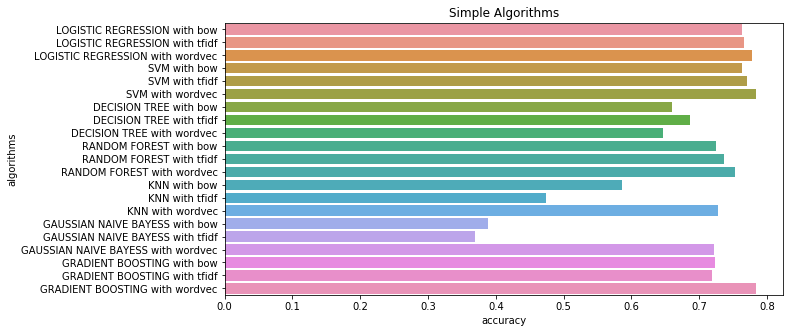

In [102]:
d = pd.DataFrame({'algorithms': algorithm_list,
                  'accuracy': accuracy_list})
plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "accuracy", y = "algorithms")
ax.set(xlabel = 'accuracy')
ax.set(title = 'Simple Algorithms')

plt.show()

# Text to sentiment attribute using TextBlob (entire dataset)

## Some more preprocessing

In [103]:
df.text = nlp_process.text

In [104]:
df.head(3)

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,Bad Flight,...,longlines,American,Delta,Southwest,US Airways,United,Virgin America,negative,neutral,positive
0,1,1.0000,0.0,0,what said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0,...,0,0,0,0,0,0,1,0,1,0
1,2,0.3486,0.0,0,plus added commercials experience tacky,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),0,...,0,0,0,0,0,0,1,0,0,1
2,1,0.6837,0.0,0,today must mean need take another trip,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),0,...,0,0,0,0,0,0,1,0,1,0


In [105]:
df = df.drop(['tweet_created','user_timezone'],axis=1)
df = df.drop(['tweet_coord','tweet_location'],axis=1)

In [106]:
from textblob import TextBlob

In [107]:
df['sentiment'] = df['text'].apply(lambda tweet: TextBlob(tweet).sentiment[0] )

In [108]:
# now we can drop the text, since we extracted its information
df = df.drop(['text'],axis=1)

In [109]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,retweet_count,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,...,American,Delta,Southwest,US Airways,United,Virgin America,negative,neutral,positive,sentiment
0,1,1.0000,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.00000
1,2,0.3486,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.00000
2,1,0.6837,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,-0.31250
3,0,1.0000,0.7033,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.00625
4,0,1.0000,1.0000,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.20000


### Delete attributes which has high correlation with target variable

In [110]:
df.corr()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,retweet_count,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,...,American,Delta,Southwest,US Airways,United,Virgin America,negative,neutral,positive,sentiment
airline_sentiment,1.000000,-0.205936,-0.808681,-0.015717,-0.143585,-0.210281,-0.175186,-0.352116,-0.050389,-0.130300,...,-0.078469,0.156957,0.124170,-0.144374,-0.074429,0.101887,-0.916402,0.319050,0.850389,0.375557
airline_sentiment_confidence,-0.205936,1.000000,0.380525,0.012581,0.031992,-0.027588,0.063319,0.157376,0.024321,0.058328,...,0.050855,-0.078693,-0.037314,0.065534,0.002588,-0.027928,0.264284,-0.244625,-0.075794,-0.105340
negativereason_confidence,-0.808681,0.380525,1.000000,0.018591,0.087603,0.126807,0.200411,0.399039,0.048818,0.092323,...,0.084402,-0.161778,-0.110509,0.153994,0.049828,-0.094758,0.882453,-0.592760,-0.501852,-0.304948
retweet_count,-0.015717,0.012581,0.018591,1.000000,-0.001379,0.040437,-0.002748,-0.004478,-0.001442,0.002181,...,-0.026005,0.017448,-0.013565,0.001890,0.021920,-0.007865,0.018643,-0.015053,-0.007793,-0.003198
Bad Flight,-0.143585,0.031992,0.087603,-0.001379,1.000000,-0.060413,-0.050331,-0.101162,-0.014477,-0.037435,...,-0.019972,-0.023453,-0.005538,-0.010004,0.051490,-0.001858,0.156683,-0.105247,-0.089106,-0.052239
Can't Tell,-0.210281,-0.027588,0.126807,0.040437,-0.060413,1.000000,-0.073710,-0.148153,-0.021201,-0.054824,...,-0.016786,0.003753,-0.025374,0.005772,0.038888,-0.026003,0.229464,-0.154135,-0.130496,-0.087262
Cancelled Flight,-0.175186,0.063319,0.200411,-0.002748,-0.050331,-0.073710,1.000000,-0.123427,-0.017663,-0.045674,...,0.064620,-0.063238,0.017321,0.015000,-0.026726,-0.017907,0.191168,-0.128411,-0.108717,-0.035575
Customer Service Issue,-0.352116,0.157376,0.399039,-0.004478,-0.101162,-0.148153,-0.123427,1.000000,-0.035501,-0.091802,...,0.096108,-0.115760,-0.041482,0.099457,-0.030669,-0.037721,0.384237,-0.258099,-0.218516,-0.135770
Damaged Luggage,-0.050389,0.024321,0.048818,-0.001442,-0.014477,-0.021201,-0.017663,-0.035501,1.000000,-0.013137,...,-0.004792,-0.000621,0.004584,-0.008985,0.005880,0.007673,0.054985,-0.036935,-0.031270,-0.013115
Flight Attendant Complaints,-0.130300,0.058328,0.092323,0.002181,-0.037435,-0.054824,-0.045674,-0.091802,-0.013137,1.000000,...,-0.003574,-0.013888,-0.042821,0.026196,0.037015,-0.024294,0.142186,-0.095509,-0.080862,-0.041472


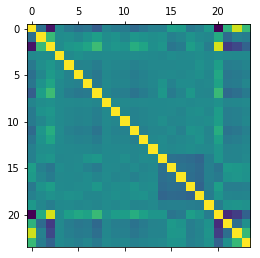

In [111]:
plt.matshow(df.corr())
plt.show()

In [112]:
df = df.drop(['airline_sentiment_confidence','negativereason_confidence'],axis=1)

In [113]:
X = df.iloc[:,1:18]
y = df.iloc[:,0]

In [114]:
X_short = X

In [115]:
X = pd.concat((X, df.sentiment), axis = 1)

### We observe that  the correlation between the train variables is now low

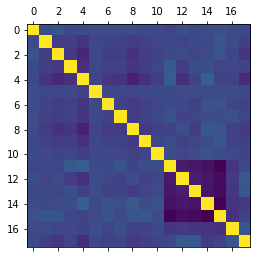

In [116]:
plt.matshow(X.corr())
plt.show()

## Now re-apply our algorithms

Without sentiment column

In [117]:
accuracy_list = [] # empty list in order to see the results after textBlob

In [118]:
logistic(X_short,y)

Accuracy: 0.8419854280510018
Confusion matrix:
 [[2814    0    0]
 [   0  882    2]
 [   0  692    2]]

Elapsed time: 0.31154584884643555 sec


With sentiment column

In [119]:
logistic(X,y)

Accuracy: 0.8886612021857924
Confusion matrix:
 [[2814    0    0]
 [   0  759  125]
 [   0  364  330]]

Elapsed time: 0.2728097438812256 sec


In [120]:
svm(X_short,y)

Accuracy: 0.8417577413479053
Confusion matrix:
 [[2814    0    0]
 [   0  883    1]
 [   0  694    0]]

Elapsed time: 0.43847036361694336 sec


In [121]:
svm(X,y)

Accuracy: 0.8879781420765027
Confusion matrix:
 [[2814    0    0]
 [   0  764  120]
 [   0  372  322]]

Elapsed time: 0.43920254707336426 sec


In [122]:
dectree(X_short,y)

Accuracy: 0.839936247723133
Confusion matrix:
 [[2727    0    0]
 [   0  953   13]
 [   0  690    9]]

Elapsed time: 0.009992361068725586 sec


In [123]:
dectree(X,y)

Accuracy: 0.8957194899817851
Confusion matrix:
 [[2759    0    0]
 [   0  731  188]
 [   0  270  444]]

Elapsed time: 0.014990091323852539 sec


In [124]:
randforest(X_short,y)

Accuracy: 0.837431693989071
Confusion matrix:
 [[2759    0    0]
 [   0  913    4]
 [   0  710    6]]

Elapsed time: 0.38869500160217285 sec


In [125]:
randforest(X,y)

Accuracy: 0.9023224043715847
Confusion matrix:
 [[2757    0    0]
 [   0  756  184]
 [   0  245  450]]

Elapsed time: 0.5024726390838623 sec


In [126]:
KNN(X_short,y)

Accuracy: 0.8337887067395264
Confusion matrix:
 [[2730    5    5]
 [   2  922    9]
 [   2  707   10]]

Elapsed time: 0.21482810000003383 sec


In [127]:
KNN(X,y)

Accuracy: 0.8779599271402551
Confusion matrix:
 [[2678   10    1]
 [   3  781  161]
 [   2  359  397]]

Elapsed time: 0.17744900000002417 sec


In [128]:
nb(X_short,y)

Accuracy: 0.8360655737704918
Confusion matrix:
 [[2736    0    0]
 [   0  890   48]
 [   0  672   46]]

Elapsed time: 0.010323599999992439 sec


In [129]:
nb(X,y)

Accuracy: 0.8852459016393442
Confusion matrix:
 [[2782    0    0]
 [   0  786  121]
 [   0  383  320]]

Elapsed time: 0.007108300000027157 sec


In [130]:
gb(X_short,y)

Accuracy: 0.8449453551912568
Confusion matrix:
 [[915   0   0]
 [  0 322   0]
 [  0 227   0]]

Elapsed time: 2.471053123474121 sec


In [131]:
gb(X,y)

Accuracy: 0.9050546448087432
Confusion matrix:
 [[918   0   0]
 [  0 244  63]
 [  0  76 163]]

Elapsed time: 3.265331983566284 sec


## Diagram of Simple algorithms after textblob proccessing of the text.

In [132]:
algorithm_list = []
algorithm_list.append('LOGISTIC REGRESSION without Sentiment Column')
algorithm_list.append('LOGISTIC REGRESSION with Sentiment Column')

algorithm_list.append('SVM without Sentiment Column')
algorithm_list.append('SVM with Sentiment Column')

algorithm_list.append('DECISION TREE without Sentiment Column')
algorithm_list.append('DECISION TREE with Sentiment Column')

algorithm_list.append('RANDOM FOREST without Sentiment Column')
algorithm_list.append('RANDOM FOREST with Sentiment Column')

algorithm_list.append('KNN without Sentiment Column')
algorithm_list.append('KNN with Sentiment Column')


algorithm_list.append('GAUSSIAN NAIVE BAYESS without Sentiment Column')
algorithm_list.append('GAUSSIAN NAIVE BAYESS with Sentiment Column')

algorithm_list.append('GRADIENT BOOSTING without Sentiment Column')
algorithm_list.append('GRADIENT BOOSTING with Sentiment Column')

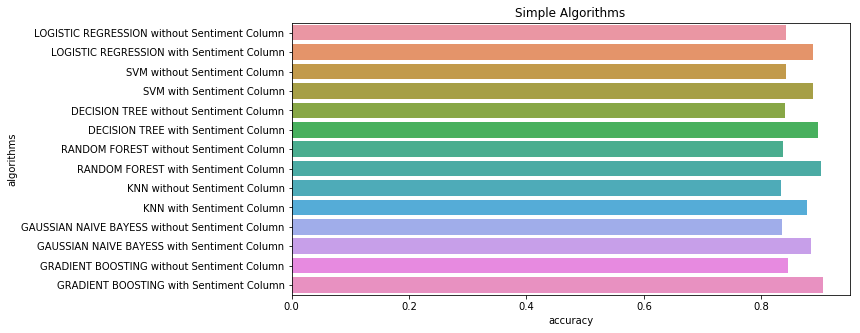

In [133]:
d = pd.DataFrame({'algorithms': algorithm_list,
                  'accuracy': accuracy_list})
plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "accuracy", y = "algorithms")
ax.set(xlabel = 'accuracy')
ax.set(title = 'Simple Algorithms')

plt.show()

# Sentiment Analysis with Keras (Neural Networks)

## Load some libraries

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import re

## Simple Keras Classifier

### Load some libraries

In [135]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras import optimizers

In [136]:
accuracy_list_NN = []
time_list = []

### with kfolds evaluation

In [137]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [138]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [139]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=18, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [140]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=2)

In [141]:
# evaluate with kfolds
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [142]:
start_time = time.time()
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
elapsed_time = time.time() - start_time
acc, std = results.mean()*100, results.std()*100
print("Accuracy: %.2f%% \nStd. Deviation: (%.2f%%)" % (acc, std))
print ('\nElapsed time:', elapsed_time, 'sec')

accuracy_list_NN.append(acc/100)
time_list.append(elapsed_time)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 3s - loss: 0.5002 - acc: 0.7625
Epoch 2/10
 - 2s - loss: 0.2304 - acc: 0.8886
Epoch 3/10
 - 2s - loss: 0.2191 - acc: 0.8915
Epoch 4/10
 - 2s - loss: 0.2173 - acc: 0.8967
Epoch 5/10
 - 2s - loss: 0.2166 - acc: 0.8990
Epoch 6/10
 - 2s - loss: 0.2163 - acc: 0.8983
Epoch 7/10
 - 2s - loss: 0.2165 - acc: 0.8991
Epoch 8/10
 - 2s - loss: 0.2164 - acc: 0.9009
Epoch 9/10
 - 3s - loss: 0.2160 - acc: 0.9002
Epoch 10/10
 - 3s - loss: 0.2162 - acc: 0.9001
Epoch 1/10
 - 3s - loss: 0.4956 - acc: 0.7630
Epoch 2/10
 - 3s - loss: 0.2275 - acc: 0.8865
Epoch 3/10
 - 2s - loss: 0.2202 - acc: 0.8870
Epoch 4/10
 - 3s - loss: 0.2193 - acc: 0.8872
Epoch 5/10
 - 3s - loss: 0.2187 - acc: 0.8907
Epoch 6/10
 - 3s - loss: 0.2184 - acc: 0.8919
Epoch 7/10
 - 2s - loss: 0.2180 - acc: 0.8946
Epoch 8/10
 - 2s - loss: 0.2174 - acc: 0.8937
Epoch 9/10
 - 2s - loss: 0.2169 - acc: 0.8963
Epoch

### with train/test split

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X,dummy_y, test_size = 0.3)

In [144]:
def model_1(name):
    # create model
    model = Sequential()
    # hidden layer
    model.add(Dense(8, input_dim=18, activation='relu'))
    # output layer
    model.add(Dense(3, activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer= name , metrics=['accuracy'])
    
    return (model)


#### try different optimizers

In [145]:
name = 'adam'

model = model_1(name)

model.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose = 2)

loss,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 32)

print("\nloss: %.2f" % (loss))
print("acc: %.2f %%" % (acc*100))

Epoch 1/10
 - 1s - loss: 0.8338 - acc: 0.5742
Epoch 2/10
 - 0s - loss: 0.5446 - acc: 0.6929
Epoch 3/10
 - 0s - loss: 0.3970 - acc: 0.8218
Epoch 4/10
 - 0s - loss: 0.3232 - acc: 0.8642
Epoch 5/10
 - 0s - loss: 0.2661 - acc: 0.8761
Epoch 6/10
 - 0s - loss: 0.2387 - acc: 0.8843
Epoch 7/10
 - 0s - loss: 0.2286 - acc: 0.8881
Epoch 8/10
 - 0s - loss: 0.2240 - acc: 0.8885
Epoch 9/10
 - 0s - loss: 0.2217 - acc: 0.8888
Epoch 10/10
 - 0s - loss: 0.2201 - acc: 0.8900

loss: 0.23
acc: 88.78 %


In [146]:
sgd = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
model = model_1(sgd)

In [147]:
batch_size = 5
model.fit(X_train, y_train, epochs = 30, batch_size = batch_size, verbose = 2)

Epoch 1/30
 - 3s - loss: 0.5754 - acc: 0.7555
Epoch 2/30
 - 2s - loss: 0.2621 - acc: 0.8835
Epoch 3/30
 - 2s - loss: 0.2336 - acc: 0.8865
Epoch 4/30
 - 2s - loss: 0.2296 - acc: 0.8864
Epoch 5/30
 - 2s - loss: 0.2306 - acc: 0.8876
Epoch 6/30
 - 2s - loss: 0.2223 - acc: 0.8904
Epoch 7/30
 - 2s - loss: 0.2265 - acc: 0.8893
Epoch 8/30
 - 2s - loss: 0.2300 - acc: 0.8904
Epoch 9/30
 - 2s - loss: 0.2374 - acc: 0.8897
Epoch 10/30
 - 2s - loss: 0.2249 - acc: 0.8915
Epoch 11/30
 - 2s - loss: 0.2190 - acc: 0.8923
Epoch 12/30
 - 2s - loss: 0.2183 - acc: 0.8931
Epoch 13/30
 - 2s - loss: 0.2261 - acc: 0.8935
Epoch 14/30
 - 2s - loss: 0.2307 - acc: 0.8931
Epoch 15/30
 - 2s - loss: 0.2224 - acc: 0.8948
Epoch 16/30
 - 2s - loss: 0.2173 - acc: 0.8960
Epoch 17/30
 - 2s - loss: 0.2167 - acc: 0.8957
Epoch 18/30
 - 2s - loss: 0.2241 - acc: 0.8960
Epoch 19/30
 - 2s - loss: 0.2169 - acc: 0.8986
Epoch 20/30
 - 2s - loss: 0.2158 - acc: 0.8968
Epoch 21/30
 - 2s - loss: 0.2161 - acc: 0.8983
Epoch 22/30
 - 2s - lo

In [148]:
loss,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)

In [149]:
print("loss: %.2f" % (loss))
print("acc: %.2f %%" % (acc*100))

loss: 0.22
acc: 89.87 %


In [150]:
rms = optimizers.RMSprop(lr=0.01)
model = model_1(rms)

In [151]:
model.fit(X_train, y_train, epochs = 7, batch_size = batch_size, verbose = 2)

loss,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)

print("\nloss: %.2f" % (loss))
print("acc: %.2f %%" % (acc*100))

Epoch 1/7
 - 3s - loss: 0.2736 - acc: 0.8746
Epoch 2/7
 - 2s - loss: 0.2266 - acc: 0.8947
Epoch 3/7
 - 2s - loss: 0.2269 - acc: 0.8977
Epoch 4/7
 - 2s - loss: 0.2290 - acc: 0.8980
Epoch 5/7
 - 2s - loss: 0.2284 - acc: 0.8966
Epoch 6/7
 - 2s - loss: 0.2282 - acc: 0.8976
Epoch 7/7
 - 2s - loss: 0.2249 - acc: 0.8986

loss: 0.23
acc: 89.78 %


In [152]:
ada = optimizers.Adagrad(lr=0.1, epsilon=None, decay=0.01)
model = model_1(ada)

In [153]:
model.fit(X_train, y_train, epochs = 7, batch_size = batch_size, verbose = 2)

loss,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)

print("\nloss: %.2f" % (loss))
print("acc: %.2f %%" % (acc*100))

Epoch 1/7
 - 3s - loss: 0.3363 - acc: 0.8321
Epoch 2/7
 - 2s - loss: 0.2833 - acc: 0.8463
Epoch 3/7
 - 2s - loss: 0.2772 - acc: 0.8509
Epoch 4/7
 - 2s - loss: 0.2742 - acc: 0.8558
Epoch 5/7
 - 2s - loss: 0.2724 - acc: 0.8598
Epoch 6/7
 - 2s - loss: 0.2711 - acc: 0.8614
Epoch 7/7
 - 2s - loss: 0.2702 - acc: 0.8624

loss: 0.27
acc: 85.95 %


In [154]:
nadam = optimizers.Nadam(lr=0.002, epsilon=None, schedule_decay=0.004)
model = model_1(nadam)

In [155]:
model.fit(X_train, y_train, epochs = 10, batch_size = None, verbose = 2)

loss,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = None)

print("\nloss: %.2f" % (loss))
print("acc: %.2f %%" % (acc*100))

Epoch 1/10
 - 1s - loss: 0.6968 - acc: 0.6594
Epoch 2/10
 - 0s - loss: 0.3534 - acc: 0.8739
Epoch 3/10
 - 0s - loss: 0.2621 - acc: 0.8843
Epoch 4/10
 - 0s - loss: 0.2362 - acc: 0.8884
Epoch 5/10
 - 0s - loss: 0.2253 - acc: 0.8883
Epoch 6/10
 - 0s - loss: 0.2216 - acc: 0.8884
Epoch 7/10
 - 0s - loss: 0.2197 - acc: 0.8883
Epoch 8/10
 - 0s - loss: 0.2191 - acc: 0.8874
Epoch 9/10
 - 0s - loss: 0.2184 - acc: 0.8894
Epoch 10/10
 - 0s - loss: 0.2182 - acc: 0.8868

loss: 0.22
acc: 88.34 %


## Convolutional Neural Network

### Load some libraries and save a useful function

In [156]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import Dense, Input, Flatten, Dropout, GlobalMaxPooling1D

In [157]:
# visualize function
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Preprocessing for CNN

In [158]:
CNN_X = nlp_process_neural['text'].values
CNN_X

array(['what said', 'plus added commercials experience tacky',
       'today must mean need take another trip', ...,
       'please bring american airlines #blackberry',
       'money change flight answer phones suggestions make commitment',
       'need know many seats next flight standby people next flight'],
      dtype=object)

In [159]:
dummy_y

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(CNN_X,dummy_y, test_size = 0.3)

Word embedding

Note: Pay close attention to the difference between this technique and the X_train that was produced by scikit-learn’s CountVectorizer.

With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index.


In [161]:
# tokenize input
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 

In [162]:
X_train

[[30, 467, 4094, 2952, 23, 177, 101, 35],
 [11, 76, 93],
 [262, 1391, 831, 12, 4095, 159, 12, 159, 163],
 [1950, 18, 832, 1, 372],
 [32, 102, 437, 66, 269, 378, 143, 1022, 533, 102, 457, 378, 348],
 [64, 1, 65, 1, 94, 1297, 164, 4096],
 [2953, 189, 189, 67, 664, 2, 4097],
 [1023, 2350, 1951, 79, 18, 9, 2350, 61, 418, 948],
 [56, 245, 135, 23, 43],
 [1024, 163, 468, 361, 281, 1714, 44, 1106, 95],
 [630, 4098, 30, 20, 11],
 [4099, 4100, 33, 230, 35, 146, 157, 949, 68, 75, 57, 379, 342, 1025, 147, 20],
 [246, 2954, 16, 312, 950, 25, 25, 60, 1952, 5],
 [1953, 238, 8, 5, 2955, 1715, 111, 606, 111, 513, 182],
 [50, 15],
 [118, 122, 2, 4101, 122, 1107],
 [1298, 1954, 606, 111, 45, 320, 257],
 [105, 75, 413, 631, 4102, 2956, 951, 884, 170, 4103, 1204, 1026],
 [569],
 [148, 952, 2351, 1392, 833, 1393, 2957, 4104, 4105, 2, 4106],
 [76, 6, 28],
 [135, 31, 1, 127, 349, 43, 36, 38],
 [64, 494, 46, 17, 203, 1299, 94, 195, 7, 81, 1],
 [14],
 [717, 373, 58, 343, 1716, 8, 5, 4107],
 [21, 98, 7, 548, 10

In [163]:
# sequence padding to make every text sequence of same length (pad with 0's)
maxlen = 14

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [164]:
X_train

array([[  30,  467, 4094, ...,    0,    0,    0],
       [  11,   76,   93, ...,    0,    0,    0],
       [ 262, 1391,  831, ...,    0,    0,    0],
       ...,
       [3772,  342,  206, ...,  206,    0,    0],
       [2938,  102, 2938, ...,    0,    0,    0],
       [   3,  669,   30, ...,    0,    0,    0]])

### Keras embedding layer simple neural network

In [165]:
# define model
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                   output_dim=embedding_dim, 
                   input_length=maxlen,
                   trainable=True))
model.add(GlobalMaxPooling1D())
#model.add(Dropout(0.2)) # that's to avoid overfitting if need be
#model.add(Flatten()) # if we leave this and remove maxpooling
                      #the accuracy of the training set drops
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

# compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#check our model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 50)            457450    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 33        
Total params: 457,993
Trainable params: 457,993
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10248 samples, validate on 4392 samples
Epoch 1/4
 - 31s - loss: 0.4127 - acc: 0.8178 - val_loss: 0.3531 - val_acc: 0.8479
Epoch 2/4
 - 31s - loss: 0.2924 - acc: 0.8787 - val_loss: 0.3392 - val_acc: 0.8542
Epoch 3/4
 - 35s - loss: 0.2279 - acc: 0.9085 - val_loss: 0.3522 - val_acc: 0.8544
Epoch 4/4
 - 32s - loss: 0.1786 - acc: 0.9315 - val_loss: 0.3843 - val_acc: 0.8486
Training Accuracy: 0.9564
Testing Accuracy:  0.8486
Time elapsed: 130.76282501220703 sec


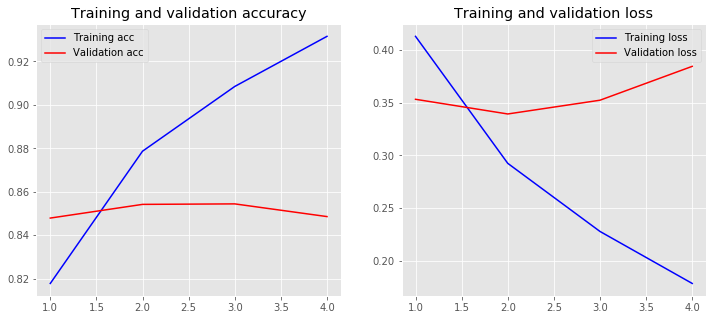

In [166]:
# train model
start = time.time()
history = model.fit(X_train, y_train,
                    epochs = 4,
                    verbose = 2,
                    validation_data=(X_test, y_test),
                    batch_size=2)
elapsed_time = time.time() - start

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
accuracy_list_NN.append(accuracy)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

print ('Time elapsed:', elapsed_time, 'sec')
time_list.append(elapsed_time)

### CNN

In [167]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 100)           914900    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 33        
Total params: 980,351
Trainable params: 980,351
Non-trainable params: 0
_________________________________________________________________


Train on 10248 samples, validate on 4392 samples
Epoch 1/7
 - 21s - loss: 0.3953 - acc: 0.8239 - val_loss: 0.3371 - val_acc: 0.8544
Epoch 2/7
 - 17s - loss: 0.2603 - acc: 0.8922 - val_loss: 0.3538 - val_acc: 0.8498
Epoch 3/7
 - 16s - loss: 0.1636 - acc: 0.9365 - val_loss: 0.4055 - val_acc: 0.8449
Epoch 4/7
 - 17s - loss: 0.0937 - acc: 0.9657 - val_loss: 0.5355 - val_acc: 0.8413
Epoch 5/7
 - 16s - loss: 0.0588 - acc: 0.9794 - val_loss: 0.6415 - val_acc: 0.8335
Epoch 6/7
 - 16s - loss: 0.0445 - acc: 0.9833 - val_loss: 0.7057 - val_acc: 0.8236
Epoch 7/7
 - 18s - loss: 0.0376 - acc: 0.9865 - val_loss: 0.7612 - val_acc: 0.8321
Training Accuracy: 0.9910
Testing Accuracy:  0.8321
Time elapsed: 122.55640172958374 sec


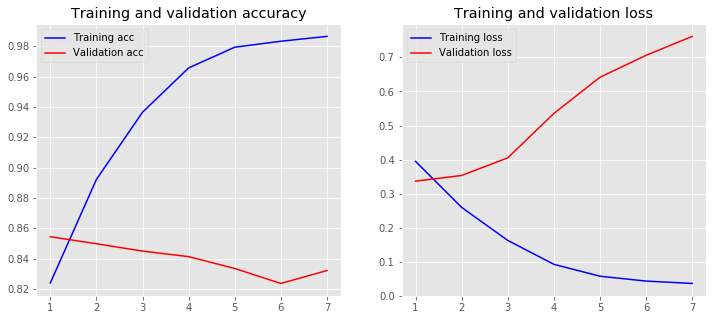

In [168]:
# train model
start = time.time()
history = model.fit(X_train, y_train,
                    epochs = 7,
                    verbose = 2,
                    validation_data=(X_test, y_test),
                    batch_size=10)
elapsed_time = time.time() - start

loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
accuracy_list_NN.append(accuracy)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

time_list.append(elapsed_time)
print ('Time elapsed:', elapsed_time, 'sec')

## Grid search for simple NN with 2 hidden layers and with 3 output units

### Using Dataset with sentiment atribute (Textblob)

In [169]:
from sklearn.pipeline import Pipeline

In [170]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [171]:
X = df.iloc[:,1:-4]
xx = df.iloc[:,-1]

In [172]:
X = pd.concat((X,df.sentiment),axis=1)
Y = df.iloc[:,-4:-1]

In [173]:
# define baseline model

# create model
model = Sequential()
model.add(Dense(20, input_dim=X.shape[1], activation='relu'))
model.add(Dense(10,  activation='relu'))
model.add(Dense(3, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 20)                380       
_________________________________________________________________
dense_36 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 33        
Total params: 623
Trainable params: 623
Non-trainable params: 0
_________________________________________________________________
None


In [174]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [175]:
batch_size = 100
start = time.time()
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)
elapsed = time.time() - start

Epoch 1/10
 - 1s - loss: 0.8466 - acc: 0.6007
Epoch 2/10
 - 0s - loss: 0.5365 - acc: 0.6703
Epoch 3/10
 - 0s - loss: 0.3866 - acc: 0.8408
Epoch 4/10
 - 0s - loss: 0.3041 - acc: 0.8822
Epoch 5/10
 - 0s - loss: 0.2521 - acc: 0.8836
Epoch 6/10
 - 0s - loss: 0.2341 - acc: 0.8861
Epoch 7/10
 - 0s - loss: 0.2271 - acc: 0.8876
Epoch 8/10
 - 0s - loss: 0.2247 - acc: 0.8902
Epoch 9/10
 - 0s - loss: 0.2229 - acc: 0.8896
Epoch 10/10
 - 0s - loss: 0.2221 - acc: 0.8929


In [176]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
accuracy_list_NN.append(acc)
print("loss: %.2f" % (score))
print("acc: %.2f" % (acc))

print ('elapsed time:', elapsed_time, 'sec')
time_list.append(elapsed_time)

loss: 0.22
acc: 0.88
elapsed time: 122.55640172958374 sec


### Grid-search using MLP on whole dataset

In [177]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

In [178]:
from sklearn.neural_network import MLPClassifier

In [179]:
# store models for later use
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
n_hidden_neurons=20
epochs = 30

X_train, X_test, Y_train, Y_test = train_test_split(X,df.airline_sentiment,
                                                    test_size = 0.33, random_state = 42)

start = time.time()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        
        DNN_scikit[i][j] = dnn
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", dnn.score(X_test, Y_test))
        print()
        
elapsed_time = time.time() - start
time_list.append(elapsed_time)
print ('elapsed time:', elapsed_time, 'sec')

C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.20364238410596028



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.44908940397350994



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.6382450331125827



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.01
Accuracy score on test set:  0.2889072847682119



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  0.1
Accuracy score on test set:  0.20364238410596028



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.15790562913907286



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1e-05
Lambda =  10.0
Accuracy score on test set:  0.5701572847682119



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.0001
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.001
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.01
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  0.1
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  1.0
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.0001
Lambda =  10.0
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  1e-05
Accuracy score on test set:  0.8795529801324503



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.0001
Accuracy score on test set:  0.8783112582781457



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.001
Accuracy score on test set:  0.8816225165562914



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.01
Accuracy score on test set:  0.8824503311258278



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  0.1
Accuracy score on test set:  0.8766556291390728



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  1.0
Accuracy score on test set:  0.7932533112582781



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.001
Lambda =  10.0
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  1e-05
Accuracy score on test set:  0.8899006622516556



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.0001
Accuracy score on test set:  0.8990066225165563



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.001
Accuracy score on test set:  0.9037665562913907



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.01
Accuracy score on test set:  0.9029387417218543



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  0.1
Accuracy score on test set:  0.8870033112582781



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  1.0
Accuracy score on test set:  0.8375413907284768



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.01
Lambda =  10.0
Accuracy score on test set:  0.6384519867549668



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.1
Lambda =  1e-05
Accuracy score on test set:  0.9021109271523179



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.1
Lambda =  0.0001
Accuracy score on test set:  0.9029387417218543



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.1
Lambda =  0.001
Accuracy score on test set:  0.9043874172185431

Learning rate  =  0.1
Lambda =  0.01
Accuracy score on test set:  0.8979718543046358



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  0.1
Lambda =  0.1
Accuracy score on test set:  0.8785182119205298

Learning rate  =  0.1
Lambda =  1.0
Accuracy score on test set:  0.8389900662251656

Learning rate  =  0.1
Lambda =  10.0
Accuracy score on test set:  0.6384519867549668

Learning rate  =  1.0
Lambda =  1e-05
Accuracy score on test set:  0.8824503311258278

Learning rate  =  1.0
Lambda =  0.0001
Accuracy score on test set:  0.8420943708609272

Learning rate  =  1.0
Lambda =  0.001
Accuracy score on test set:  0.8934188741721855

Learning rate  =  1.0
Lambda =  0.01
Accuracy score on test set:  0.8783112582781457

Learning rate  =  1.0
Lambda =  0.1
Accuracy score on test set:  0.7884933774834437



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  1.0
Lambda =  1.0
Accuracy score on test set:  0.8182947019867549

Learning rate  =  1.0
Lambda =  10.0
Accuracy score on test set:  0.6380380794701986

Learning rate  =  10.0
Lambda =  1e-05
Accuracy score on test set:  0.773385761589404

Learning rate  =  10.0
Lambda =  0.0001
Accuracy score on test set:  0.7907698675496688



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  10.0
Lambda =  0.001
Accuracy score on test set:  0.20364238410596028

Learning rate  =  10.0
Lambda =  0.01
Accuracy score on test set:  0.20364238410596028

Learning rate  =  10.0
Lambda =  0.1
Accuracy score on test set:  0.20364238410596028



C:\Users\pgrig\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Learning rate  =  10.0
Lambda =  1.0
Accuracy score on test set:  0.6384519867549668

Learning rate  =  10.0
Lambda =  10.0
Accuracy score on test set:  0.6384519867549668

elapsed time: 49.89303660392761 sec


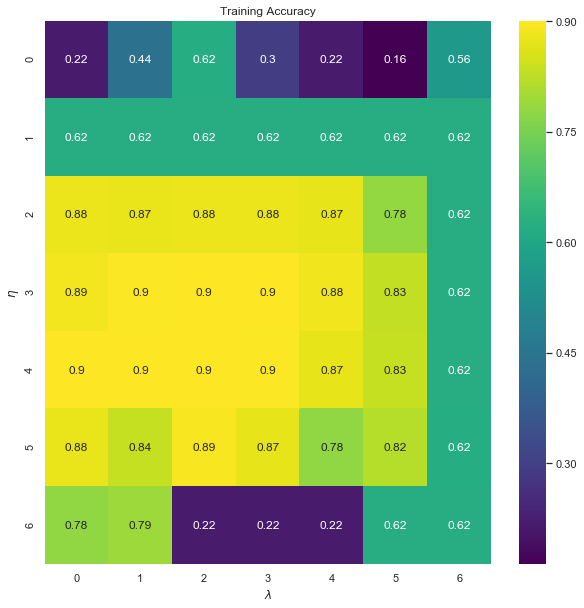

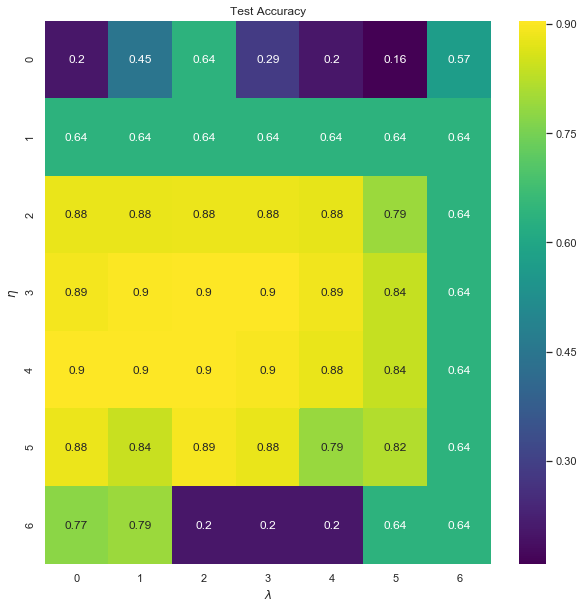

In [180]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_scikit[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [181]:
from sklearn.model_selection import GridSearchCV

## LSTM Neural Network without neutral tweets

### drop neutral tweets

In [182]:
nlp_process_neural = nlp_process_neural[nlp_process_neural['airline_sentiment'] != 'neutral']

In [183]:
nlp_process_neural.head()

,text,airline_sentiment
1,plus added commercials experience tacky,positive
3,really aggressive blast obnoxious entertainmen...,negative
4,really thing,negative
5,seriously would flight seats playing really th...,negative
6,nearly every time worm away,positive


### I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [184]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(nlp_process_neural['text'].values)
X = tokenizer.texts_to_sequences(nlp_process_neural['text'].values)
X = pad_sequences(X)

**Next, I compose the LSTM Network. Note that embed_dim, lstm_out, batch_size, droupout_x variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.**


In [185]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 17, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 17, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [186]:
Y = pd.get_dummies(nlp_process_neural['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)

In [187]:
batch_size = 32
start = time.time()
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)
elapsed_time = time.time() - start
time_list.append(elapsed_time)

Epoch 1/7
 - 12s - loss: 0.3487 - acc: 0.8553
Epoch 2/7
 - 9s - loss: 0.2005 - acc: 0.9216
Epoch 3/7
 - 10s - loss: 0.1607 - acc: 0.9370
Epoch 4/7
 - 9s - loss: 0.1370 - acc: 0.9465
Epoch 5/7
 - 10s - loss: 0.1184 - acc: 0.9540
Epoch 6/7
 - 10s - loss: 0.1039 - acc: 0.9593
Epoch 7/7
 - 12s - loss: 0.0844 - acc: 0.9662


In [188]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
loss,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
accuracy_list_NN.append(acc)

In [189]:
print("loss: %.2f" % (loss))
print("acc: %.2f" % (acc))
print('time elapsed:', elapsed_time, 'sec')

loss: 0.34
acc: 0.89
time elapsed: 73.93194437026978 sec


### measuring the number of correct guesses

In [190]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("positive accuracy:", pos_correct/pos_cnt*100, "%")
print("negative accuracy:", neg_correct/neg_cnt*100, "%")

positive accuracy: 74.15384615384616 %
negative accuracy: 93.70212765957446 %


**the positive training set is dramatically smaller than the negative**

## Graph to compare NN's accuracy

In [191]:
alg_list = ['simple NN','Simple Embedding NN' ,'CNN','2-layer Simple NN with TextBlob', 'LSTM' ]


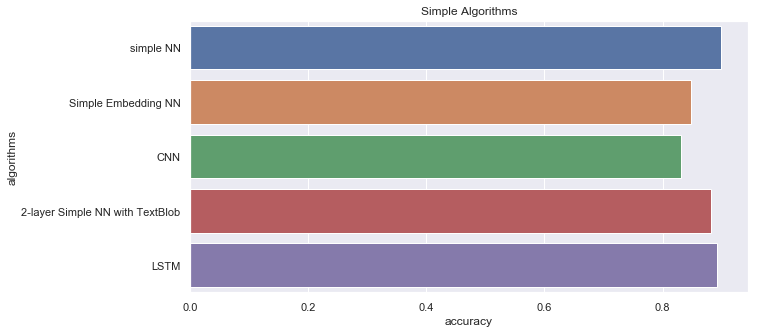

In [192]:
d = pd.DataFrame({'algorithms': alg_list,
                  'accuracy': accuracy_list_NN})
plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "accuracy", y = "algorithms")
ax.set(xlabel = 'accuracy')
ax.set(title = 'Simple Algorithms')

plt.show()

## Pie chart to compare NN's times

In [193]:
alg_list = ['simple NN - 10folds - 10 epochs',
            'Simple Embedding NN - 4 rpochs' ,
            'CNN - 7 epochs', 'simple NN - 2 layers - 10 epochs',
            'Grid search - simple NN - 10 epochs',
             'LSTM - 7 epochs' ]


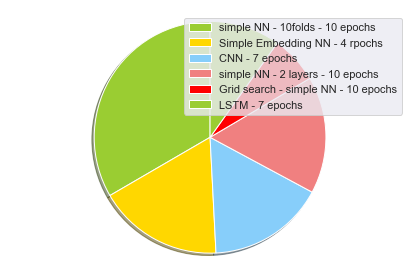

In [194]:
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','red']
patches, texts = plt.pie(time_list, colors=colors, shadow=True, startangle=90)
plt.legend(patches, alg_list, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()